In [1]:
## Chris Kellogg
## DSC680-T302

## ############################################################################
## ############################################################################
##
## Project 2
##
## The goal of this project is to look for a potential predictor or group of
## predictors that indicate that a pitcher is at increased risk for needing
## reconstructive elbow surgery.
##
## ############################################################################
## ############################################################################

In [2]:
##
## load the necessary packages
##

# import and alias Pandas
import pandas as pd

# import and alias NumPy
import numpy as np

# import and alias the plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# import the modeling and metrics packages
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# import pybaseball API
import pybaseball
from pybaseball import statcast

# suppress some warnings from pybaseball
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
##
## get a "golden record" copy of the pitch data
##

# enable caching in case there's an interruption in service
pybaseball.cache.enable()

# download the data for every pitch in the 4 years under examination
pitches_pristine = statcast(start_dt = '2021-01-01', end_dt = '2024-12-31')

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates


100%|████████████████████████████████████████████████████████████████████████████████| 984/984 [11:52<00:00,  1.38it/s]


In [4]:
##
## narrow down the data set and classify pitches
##

# start from a copy of the pristine pitch data
pitches = pitches_pristine.copy()

# keep only the pitches thrown during regular-season games
pitches = pitches.query('game_type == "R"')

# keep only the fields we want
pitches = pd.DataFrame(pitches[[
    'player_name',
    'game_year',
    'pitcher',
    'pitch_type',
    'release_speed',
    'release_spin_rate',
]])

# mark pitches as fastballs and curveballs where appropriate
pitches['fastball'] = pitches['pitch_type'].apply(
    lambda x: 1 if x in ("FF", "SI", "FC") else 0
)
pitches['breaking_ball'] = pitches['pitch_type'].apply(
    lambda x: 1 if x in ("CU", "KC", "CS", "SL", "ST", "SV") else 0
)

In [5]:
##
## aggregate the pitch data into pitcher season subsets
##

# get the total pitch count for each year
all = pitches \
    .groupby(['game_year', 'pitcher', 'player_name']) \
    .agg(
        pitch_count = ('pitch_type', 'count')
    ) \
    .query('pitch_count >= 2000') \
    .reset_index()

# get the mean velo, max velo, and count for each year
fb = pitches \
    .query('fastball == 1') \
    .groupby(['game_year', 'pitcher', 'player_name']) \
    .agg(
        fb_count = ('pitch_type', 'count'),
        fb_mean_velo = ('release_speed', 'mean'),
        fb_max_velo = ('release_speed', 'max')
    )
fb['max_effort'] = fb.fb_mean_velo / fb.fb_max_velo

# get the mean velo, max velo, and count for each year
bb = pitches \
    .query('breaking_ball == 1') \
    .groupby(['game_year', 'pitcher', 'player_name']) \
    .agg(
        bb_count = ('pitch_type', 'count'),
        bb_mean_spin = ('release_spin_rate', 'mean'),
        bb_max_spin = ('release_spin_rate', 'max')
    )
bb['spin_effort'] = bb.bb_mean_spin / bb.bb_max_spin

In [6]:
##
## merge the subsets into pitcher season data
##

# add pitch data onto the season data
pitches = pd.merge(
    all,
    fb,
    how = 'left',
    on = ['game_year', 'pitcher', 'player_name']
)

# add fastball data onto the season data
pitches = pd.merge(
    pitches,
    bb,
    how = 'left',
    on = ['game_year', 'pitcher', 'player_name']
)

# rename some columns
pitches.rename(
    columns={'game_year': 'season', 'pitcher': 'mlbamid'},
    inplace=True
)

In [7]:
##
## get the tommy john surgery info
##

# read the rows and columns we care about from the csv
tj = pd.read_csv(
    'tjs_list.csv',
    usecols=[
        'Level',
        'Position',
        'mlbamid',
        'Year',
        'Month',
        'Day'
    ]
) \
.dropna(subset=['mlbamid']) \
.query('Level == "MLB"') \
.query('Position == "P"') \
.query('Year > 2020')

# drop the columns that were just for filtering
tj.drop(columns=['Level', 'Position'], inplace=True)

# rename some columns
tj.rename(
    columns={'game_year': 'season', 'pitcher': 'mlbamid'},
    inplace=True
)

# make sure the ID is an integer
tj.mlbamid = tj.mlbamid.astype('Int64')

In [8]:
##
## merge the subsets into pitcher season data
##

# merge the data frames based on the player ID
df = pd.merge(
    pitches,
    tj,
    how = 'left',
    on = ['mlbamid']
)

# rename some columns
df.rename(
    columns={'Year': 'tjs_year', 'Month': 'tjs_month', 'Day': 'tjs_day'},
    inplace=True
)

# make sure the date info is integer
df.tjs_year = df.tjs_year.astype('Int64')
df.tjs_month = df.tjs_month.astype('Int64')
df.tjs_day = df.tjs_day.astype('Int64')

In [9]:
##
## mark the 2000-pitch seasons that preceded TJS
##

# define a function to evaluate a season
def preceded_tjs(row) :
    if not pd.isna(row.tjs_year) :
        if row.tjs_year == row.season : val = 1
        elif row.tjs_year == row.season + 1 :
            if row.tjs_month < 9 : val = 1
            elif row.tjs_month == 9 :
                if row.tjs_day < 15 : val = 1
                else : val = 0
            else : val = 0
        else:
            val = 0
    else:
        val = 0
            
    return val

# apply the function to each row to set the flags
df['preceded_tjs'] = df.apply(preceded_tjs, axis=1)

# drop the fields that aren't useful for modeling
df.drop(
    columns=[
        'season',
        'mlbamid',
        'player_name',
        'tjs_year',
        'tjs_month',
        'tjs_day'
    ],
    inplace=True
)

# split the final data into yes/no datasets
df_yes = df.query('preceded_tjs == 1')
df_no = df.query('preceded_tjs == 0')

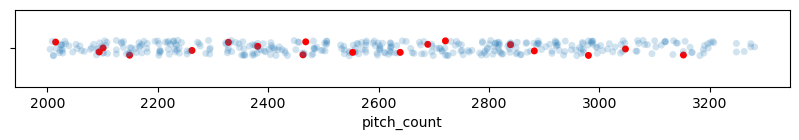

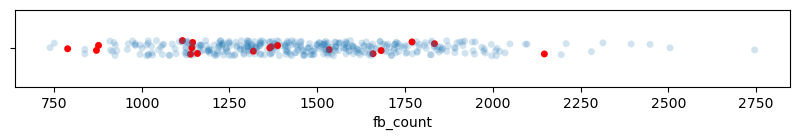

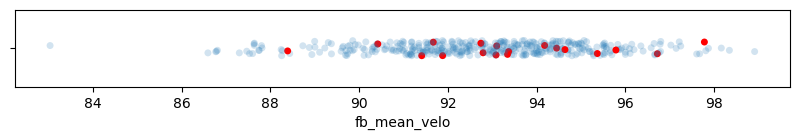

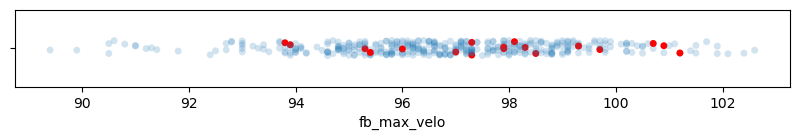

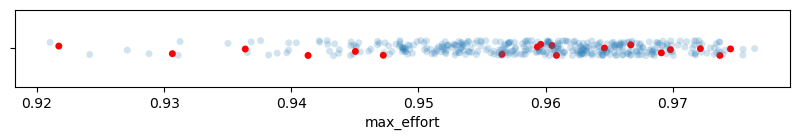

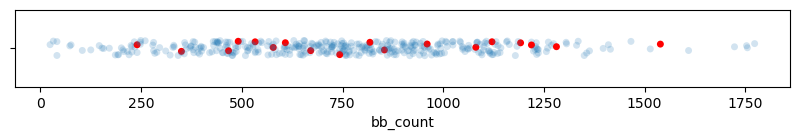

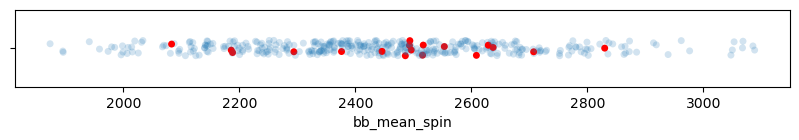

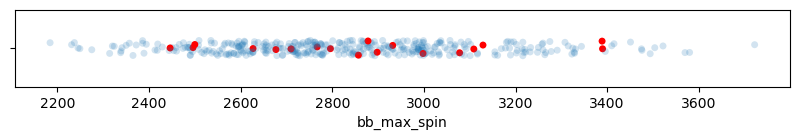

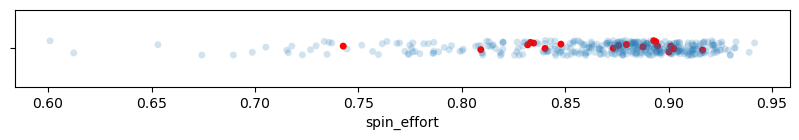

In [10]:
##
## plot each variable to look for patterns
##

# set the alpha for yes/no classes
df['alpha'] = 0.2 + (0.8 * df.preceded_tjs)

# set the color palette
palette = {0: 'tab:blue', 1: 'red'}

# define a function to show a strip plot for a column
def plot_variable(variable) :
    plt.figure(figsize=(10, 1))
    sns.stripplot(
        x=df[variable],
        alpha=df.alpha,
        hue=df.preceded_tjs,
        palette=palette,
        jitter=0.1,
        legend=False
    )
    plt.show()

# create a plot for each column
for column in df.drop(columns=['alpha','preceded_tjs']).columns:
    plot_variable(column)

In [11]:
##
## build the modeling data sets
##

# split dataset into features and target
feature_cols = [
    'pitch_count',
    'fb_count',
    'bb_count',
    'fb_mean_velo',
    'fb_max_velo',
    'max_effort',
    'bb_mean_spin',
    'bb_max_spin',
    'spin_effort'
]
X = df[feature_cols]
y = df.preceded_tjs

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

# scale X training and testing sets
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
##
## build and run the model
##

# instantiate the model
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train_scaled, y_train)

# get predictions for the test set
y_pred = logreg.predict(X_test_scaled)

In [13]:
##
## examine a confusion matrix of the predictions
##

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[92,  0],
       [ 8,  0]], dtype=int64)

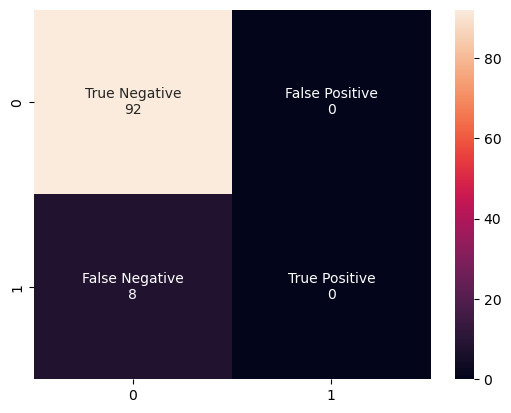

In [14]:
##
## create a visualization for the confusion matrix
##

# format the labels for the confusion matrix
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in cnf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cnf_matrix.flatten()/np.sum(cnf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)

# draw a heatmap with the confusion matrix
sns.heatmap(cnf_matrix, annot=labels, fmt='')
plt.show()

In [15]:
##
## examine a correlation matrix of the predictions
##

df_corr = df.drop(columns=['alpha']).dropna()
df_corr.corr()[['preceded_tjs']]

,preceded_tjs
pitch_count,-0.029028
fb_count,-0.075442
fb_mean_velo,0.054380
fb_max_velo,0.083063
max_effort,-0.055729
bb_count,0.044520
bb_mean_spin,0.027723
bb_max_spin,0.031646
spin_effort,-0.003684
preceded_tjs,1.000000
